# Pre-process & DataLoader

- 필요한 라이브러리 설정

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torchsummary import summary

In [ ]:
''' seed값 고정 : torch에서 사용되는 random값을 항상 같은 값이 나오도록 설정 '''
SEED = 86
torch.manual_seed(SEED)
print(torch.rand(1))

tensor([0.8674])


In [ ]:
''' torch.device('cuda')를 사용하여 학습 시 gpu를 사용할 수 있도록 설정'''
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.1+cu116  Device: cuda


In [ ]:
''' 학습할 때 모델에 한번에 입력할 데이터 갯수(batch size)와 epoch 설정'''
BATCH_SIZE = 32
EPOCH = 5

In [ ]:
''' data 불러오기 (CIFAR10) '''

# transform.Compose을 이용하여 이미지 사이즈 변경 및 데이터 타입을 변경할 수 있음
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()]
)

train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transform)

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transform)

# dataloader를 통해 batch size 설정과 데이터를 섞어서 학습에 사용할지를 결정할 수 있음
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


x_train : torch.Size([32, 3, 224, 224]) type : torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


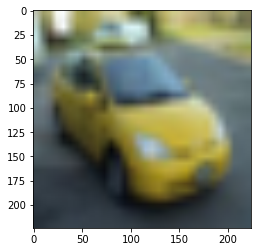

In [ ]:
# iter : 반복인자가 포함된 변수의 값을 하나씩 참조할 수 있음
# next : iter를 통해 참조한 값을 반환하고 변수 내의 값의 그 다음 위치를 참조하게 됨

x_train, y_train = next(iter(train_loader))
print('x_train :', x_train.shape, 'type :', x_train.type())
print('y_train :', y_train.shape, 'type :', y_train.type())
plt.imshow(x_train[1].permute(1, 2, 0))

# Models

- train and test code

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(DEVICE)            # .to(DEVICE) : 데이터와 모델의 gpu 호환을 위해서 사용
        y_train = y_train.to(DEVICE)

        output = model(x_train)                 # model에 훈련데이터 입력 후 변수 output에 출력값 저장
        loss = criterion(output, y_train)       # loss function을 통해 모델의 출력값과 실제 값과의 차이를 계산

        optimizer.zero_grad()                   # optimizer.zero_grad() : loss.backward()를 통해 미분을 하게 되면 optimizer에 미분값이 저장되는데 
                                                #                         미분을 진행할 때 마다 미분값이 누적되어서 정상적으로 파라미터를 업데이트 할 수 없게 되는데 
                                                #                         zero_grad()를 사용하므로써 누적된 값을 초기화 시켜줄 수 있다.
        loss.backward()                         # back propagation을 통해 각 layer 마다 미분값 계산
        optimizer.step()                        # optimizer.step() : 파라미터 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(x_train), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## LeNet

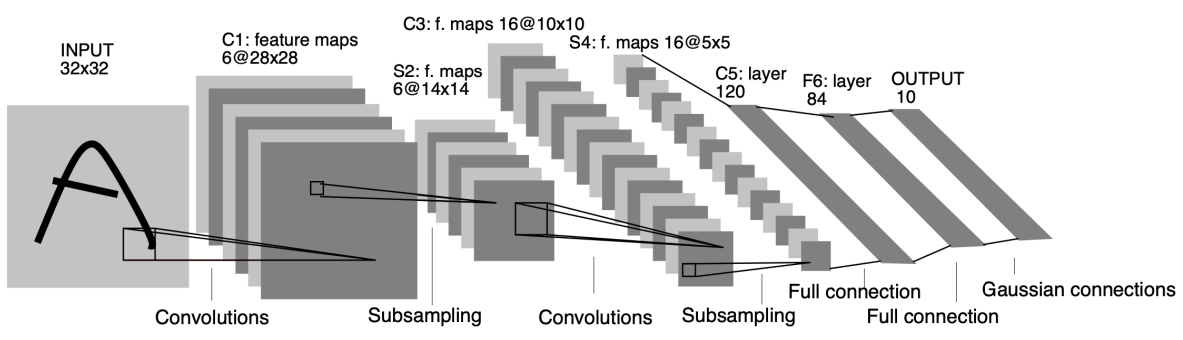

In [ ]:
class LeNet(nn.Module):

    def __init__(self, channels=3, n_classes=10):
        super(LeNet, self).__init__() 
                                            #    ==> nn.Module의 값들을 LeNet에 불러오겠다는 의미
        
        self.Convolution_layer = nn.Sequential(                                         # nn.Sequential : 네트워크의 layer를 쉽게 쌓을 수 있게 만들어 주는 메서드
            # ============================== layer 1 =================================  # input image size : 224x224
            nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5, stride=1),   # image size : 6 x ((224 - 5) / 1 + 1) = 6 x 220 x 220
            nn.Tanh(),                                                                  # image size : 6 x 220 x 220 ==> activation function에서는 이미지 크기가 변하지 않음
            nn.AvgPool2d(kernel_size=2),                                                # image size : 6 x 110 x 110

            #=============================== layer 2 =================================  
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),         # image size : 16 x ((110 - 5) / 1 + 1) = 16 x 106 x 106
            nn.Tanh(),                                                                   
            nn.AvgPool2d(kernel_size=2),                                                # image size : 16 x 53 x 53

            # ============================== layer 3 =================================  
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),       # image size : 120 x ((53 - 5) / 1 + 1) = 120 x 49 x 49
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            # ============================== layer 4 =================================
            nn.Linear(in_features=120 * 49 * 49, out_features=84),                      # nn.Linear : fully connected layer 구성 ==> 1차원 형태로 입력을 받게 됨
            nn.Tanh(),                                                                  # input image size : 120 x 49 x 49
                                                                                        # output image size : 84
            # ============================ output layer ==============================
            nn.Linear(in_features=84, out_features=n_classes),                          # output image size : 클래스 갯수(10개)
        )


    def forward(self, x):       # forward를 통해 데이터를 입력받고, 입력받은 데이터의 특징을 추출할 수 있는 연산이 진행된다.
        x = self.Convolution_layer(x) 
        x = x.view(-1, 120 * 49 * 49)   # x.view(-1, data size)     
        x = self.classifier(x)
        x = F.softmax(x, dim=1)                                                         # softmax 함수를 통해 output 값을 확률값으로 나타내줌
        return x

In [ ]:
model = LeNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
              Tanh-2          [-1, 6, 220, 220]               0
         AvgPool2d-3          [-1, 6, 110, 110]               0
            Conv2d-4         [-1, 16, 106, 106]           2,416
              Tanh-5         [-1, 16, 106, 106]               0
         AvgPool2d-6           [-1, 16, 53, 53]               0
            Conv2d-7          [-1, 120, 49, 49]          48,120
              Tanh-8          [-1, 120, 49, 49]               0
            Linear-9                   [-1, 84]      24,202,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 24,254,006
Trainable params: 24,254,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

In [ ]:
for epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.301482
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.230896
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.180029
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.215112
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.123043
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.123994
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.171939
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.133701

[EPOCH: 1], 	Test Loss: 2.1456, 	Test Accuracy: 35.82 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.167217
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.124221
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.144766
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.059565
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.135522
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.089206
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.135447
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.121238

[EPOCH: 2], 	Test Loss: 2.1159, 	Test Accuracy: 39.34 % 